In [ ]:
# 特徴量重要度分析の実装
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import numpy as np

def analyze_feature_importance(df, target_column, categorical_columns, numerical_columns):
    """
    特徴量の重要度を分析し、可視化する関数
    
    Parameters:
    -----------
    df : pd.DataFrame
        分析対象のデータフレーム
    target_column : str
        目標変数のカラム名
    categorical_columns : list
        カテゴリカル変数のリスト
    numerical_columns : list
        数値変数のリスト
    
    Returns:
    --------
    pd.DataFrame
        特徴量と重要度スコアを含むデータフレーム
    """
    
    # データのコピーを作成
    df_work = df.copy()
    
    # 目標変数を除外
    feature_cols = [col for col in categorical_columns + numerical_columns 
                   if col != target_column and col != 'id']
    
    print(f"分析対象特徴量: {len(feature_cols)}個")
    print(feature_cols)
    
    # 特徴量データフレームを準備
    X = df_work[feature_cols].copy()
    y = df_work[target_column]
    
    # カテゴリカル変数のエンコーディング
    encoders = {}
    for col in categorical_columns:
        if col in feature_cols:
            # 欠損値を'Missing'で埋める
            X[col] = X[col].fillna('Missing')
            # ラベルエンコーディング
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            encoders[col] = le
    
    # 数値変数の欠損値補完
    for col in numerical_columns:
        if col in feature_cols:
            # 中央値で補完
            median_value = X[col].median()
            X[col] = X[col].fillna(median_value)
    
    # データ型を確認
    print(f"\n前処理後のデータ形状: {X.shape}")
    print(f"欠損値の確認:")
    missing_check = X.isnull().sum()
    if missing_check.sum() > 0:
        print(missing_check[missing_check > 0])
    else:
        print("欠損値なし")
    
    # RandomForestによる特徴量重要度計算
    print(f"\nRandomForestによる特徴量重要度を計算中...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    rf_importance = rf.feature_importances_
    
    # 相互情報量による重要度計算
    print("相互情報量による特徴量重要度を計算中...")
    mi_importance = mutual_info_regression(X, y, random_state=42)
    
    # 結果をDataFrameにまとめる
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'RandomForest_Importance': rf_importance,
        'Mutual_Info_Score': mi_importance
    })
    
    # 正規化（0-1スケール）
    importance_df['RF_Normalized'] = (importance_df['RandomForest_Importance'] / 
                                     importance_df['RandomForest_Importance'].sum())
    importance_df['MI_Normalized'] = (importance_df['Mutual_Info_Score'] / 
                                     importance_df['Mutual_Info_Score'].sum())
    
    # 平均重要度を計算
    importance_df['Average_Importance'] = (importance_df['RF_Normalized'] + 
                                         importance_df['MI_Normalized']) / 2
    
    # 重要度順にソート
    importance_df = importance_df.sort_values('Average_Importance', ascending=False)
    
    # 可視化
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # RandomForest重要度
    top_features_rf = importance_df.head(10)
    axes[0].barh(range(len(top_features_rf)), top_features_rf['RandomForest_Importance'])
    axes[0].set_yticks(range(len(top_features_rf)))
    axes[0].set_yticklabels(top_features_rf['Feature'])
    axes[0].set_title('RandomForest 特徴量重要度 (Top 10)')
    axes[0].set_xlabel('重要度')
    axes[0].grid(True, alpha=0.3)
    
    # 相互情報量
    top_features_mi = importance_df.head(10)
    axes[1].barh(range(len(top_features_mi)), top_features_mi['Mutual_Info_Score'])
    axes[1].set_yticks(range(len(top_features_mi)))
    axes[1].set_yticklabels(top_features_mi['Feature'])
    axes[1].set_title('相互情報量スコア (Top 10)')
    axes[1].set_xlabel('相互情報量')
    axes[1].grid(True, alpha=0.3)
    
    # 平均重要度
    axes[2].barh(range(len(top_features_mi)), top_features_mi['Average_Importance'])
    axes[2].set_yticks(range(len(top_features_mi)))
    axes[2].set_yticklabels(top_features_mi['Feature'])
    axes[2].set_title('平均重要度 (Top 10)')
    axes[2].set_xlabel('平均重要度')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

# 実装した関数を実行
importance_df = analyze_feature_importance(
    train_df, 
    target_col,
    categorical_cols,
    numerical_cols
)

# 結果の表示
print("\n=== 特徴量重要度分析結果 ===")
print(importance_df.round(4))

# 実験000: 探索的データ分析 (EDA)

Playground Series S5E4: ポッドキャスト聴取時間予測

## 1. ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

# 表示設定
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# スタイル設定
sns.set_style('whitegrid')
plt.style.use('default')

## 2. データの読み込み

In [2]:
# データパスの設定
data_dir = Path('../../data')

# データの読み込み
train_df = pd.read_csv(data_dir / 'train.csv')
test_df = pd.read_csv(data_dir / 'test.csv')
sample_submission = pd.read_csv(data_dir / 'sample_submission.csv')

print(f"訓練データ: {train_df.shape}")
print(f"テストデータ: {test_df.shape}")
print(f"提出サンプル: {sample_submission.shape}")

訓練データ: (750000, 12)
テストデータ: (250000, 11)
提出サンプル: (250000, 2)


## 3. データの基本情報

In [3]:
# データの最初の5行を表示
print("=== 訓練データの最初の5行 ===")
train_df.head()

=== 訓練データの最初の5行 ===


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [4]:
# データ型の確認
print("=== データ型 ===")
train_df.info()

=== データ型 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usa

In [5]:
# 基本統計量
print("=== 数値カラムの基本統計量 ===")
train_df.describe()

=== 数値カラムの基本統計量 ===


,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [6]:
# カテゴリカル変数の確認
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"カテゴリカル変数: {len(categorical_cols)}個")
print(categorical_cols)
print(f"\n数値変数: {len(numerical_cols)}個")
print(numerical_cols)

カテゴリカル変数: 6個
['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

数値変数: 6個
['id', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']


## 4. 欠損値の確認

In [7]:
# 欠損値の確認
def check_missing_values(df, name):
    missing = df.isnull().sum()
    missing_percent = 100 * missing / len(df)
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percent': missing_percent
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) > 0:
        print(f"\n=== {name}の欠損値 ===")
        print(missing_df)
    else:
        print(f"\n{name}: 欠損値なし")
    return missing_df

train_missing = check_missing_values(train_df, "訓練データ")
test_missing = check_missing_values(test_df, "テストデータ")


=== 訓練データの欠損値 ===
                             Missing_Count  Missing_Percent
Guest_Popularity_percentage         146030        19.470667
Episode_Length_minutes               87093        11.612400
Number_of_Ads                            1         0.000133

=== テストデータの欠損値 ===
                             Missing_Count  Missing_Percent
Guest_Popularity_percentage          48832          19.5328
Episode_Length_minutes               28736          11.4944


## 5. 目標変数の分析

目標変数: Listening_Time_minutes


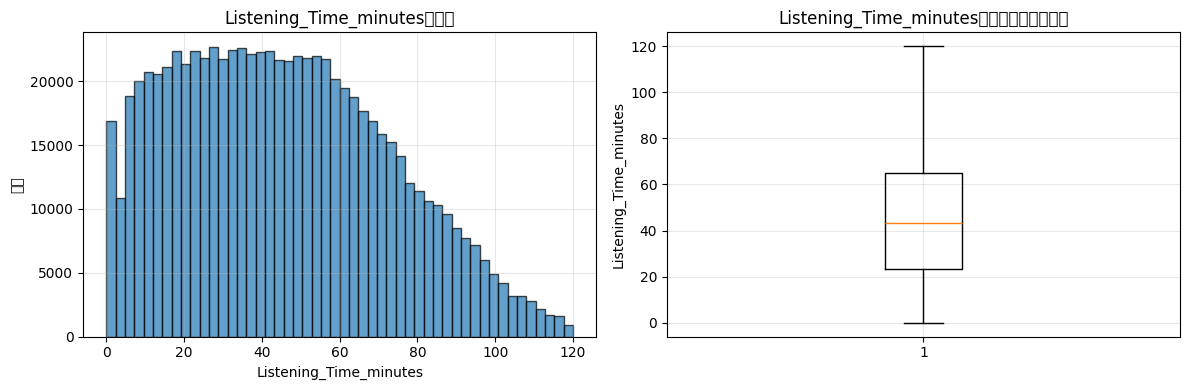


Listening_Time_minutesの統計:
平均値: 45.44
中央値: 43.38
標準偏差: 27.14
最小値: 0.00
最大値: 119.97


In [8]:
# 目標変数名を特定
target_col = None
for col in train_df.columns:
    if 'listening' in col.lower() and 'time' in col.lower():
        target_col = col
        break

if target_col:
    print(f"目標変数: {target_col}")
    
    # 目標変数の分布
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # ヒストグラム
    axes[0].hist(train_df[target_col], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel(target_col)
    axes[0].set_ylabel('頻度')
    axes[0].set_title(f'{target_col}の分布')
    axes[0].grid(True, alpha=0.3)
    
    # ボックスプロット
    axes[1].boxplot(train_df[target_col].dropna())
    axes[1].set_ylabel(target_col)
    axes[1].set_title(f'{target_col}のボックスプロット')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報
    print(f"\n{target_col}の統計:")
    print(f"平均値: {train_df[target_col].mean():.2f}")
    print(f"中央値: {train_df[target_col].median():.2f}")
    print(f"標準偏差: {train_df[target_col].std():.2f}")
    print(f"最小値: {train_df[target_col].min():.2f}")
    print(f"最大値: {train_df[target_col].max():.2f}")
else:
    print("目標変数が見つかりませんでした。カラム名を確認してください。")
    print(train_df.columns.tolist())

## 6. 数値変数の分析

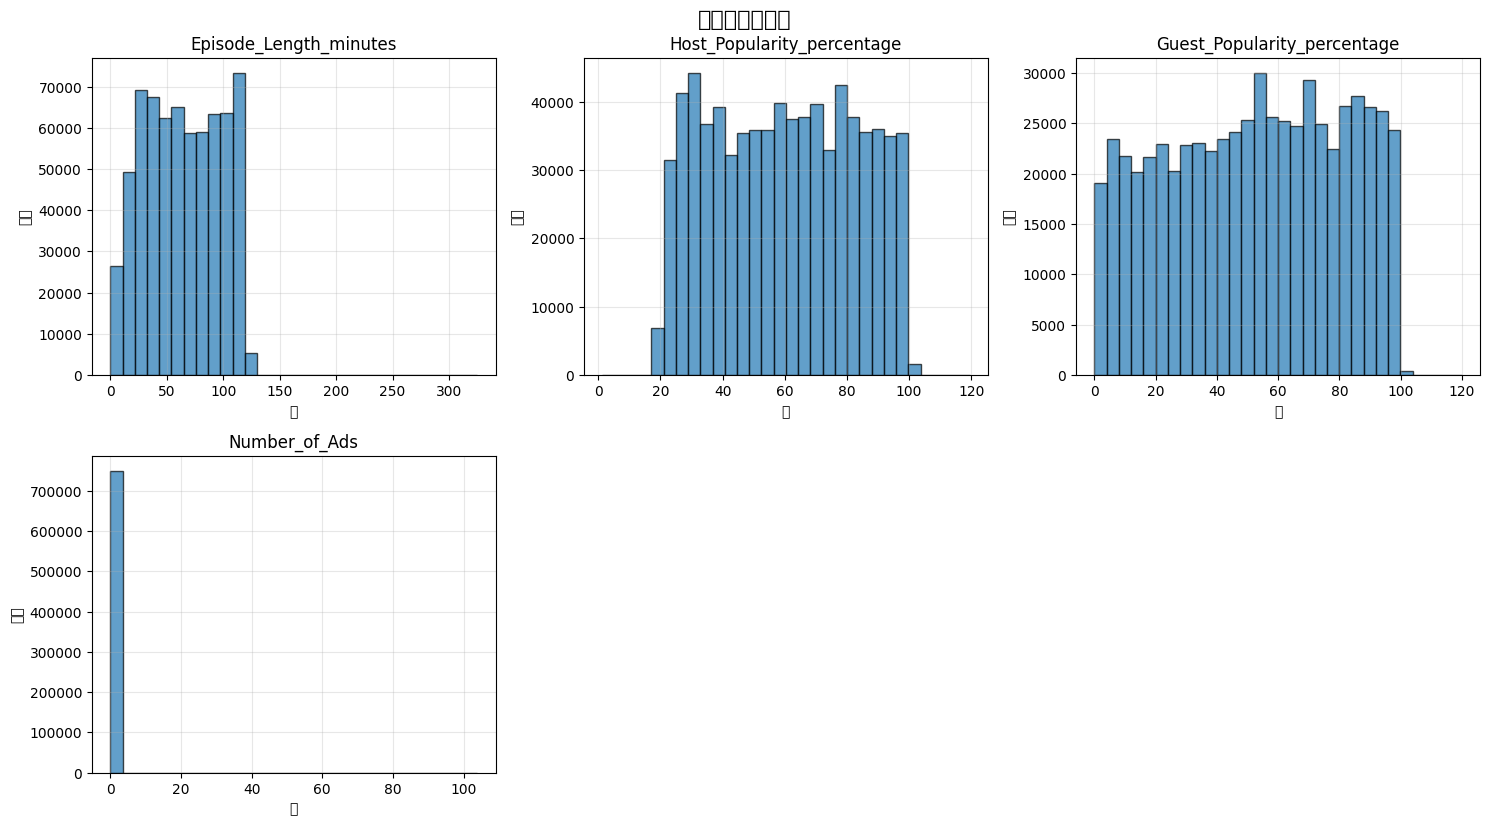

In [9]:
# 数値変数の分布を可視化
numerical_cols_no_target = [col for col in numerical_cols if col != target_col and col != 'id']

if len(numerical_cols_no_target) > 0:
    n_cols = min(len(numerical_cols_no_target), 9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols_no_target[:n_cols]):
        axes[i].hist(train_df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(col)
        axes[i].set_xlabel('値')
        axes[i].set_ylabel('頻度')
        axes[i].grid(True, alpha=0.3)
    
    # 余ったサブプロットを非表示
    for i in range(n_cols, 9):
        axes[i].set_visible(False)
    
    plt.suptitle('数値変数の分布', fontsize=16)
    plt.tight_layout()
    plt.show()

## 7. カテゴリカル変数の分析

In [10]:
# カテゴリカル変数のユニーク値数
if len(categorical_cols) > 0:
    print("=== カテゴリカル変数のユニーク値数 ===")
    for col in categorical_cols:
        n_unique = train_df[col].nunique()
        print(f"{col}: {n_unique}個")
        
        # ユニーク値が少ない場合は値の分布を表示
        if n_unique <= 10:
            print(f"  値の分布:")
            value_counts = train_df[col].value_counts()
            for val, count in value_counts.items():
                print(f"    {val}: {count} ({100*count/len(train_df):.1f}%)")
        print()

=== カテゴリカル変数のユニーク値数 ===


Podcast_Name: 48個

Episode_Title: 100個

Genre: 10個
  値の分布:
    Sports: 87606 (11.7%)
    Technology: 86256 (11.5%)
    True Crime: 85059 (11.3%)
    Lifestyle: 82461 (11.0%)
    Comedy: 81453 (10.9%)
    Business: 80521 (10.7%)
    Health: 71416 (9.5%)
    News: 63385 (8.5%)
    Music: 62743 (8.4%)
    Education: 49100 (6.5%)

Publication_Day: 7個
  値の分布:
    Sunday: 115946 (15.5%)
    Monday: 111963 (14.9%)
    Friday: 108237 (14.4%)
    Wednesday: 107886 (14.4%)
    Thursday: 104360 (13.9%)
    Saturday: 103505 (13.8%)
    Tuesday: 98103 (13.1%)

Publication_Time: 4個
  値の分布:
    Night: 196849 (26.2%)
    Evening: 195778 (26.1%)
    Afternoon: 179460 (23.9%)
    Morning: 177913 (23.7%)

Episode_Sentiment: 3個
  値の分布:
    Neutral: 251291 (33.5%)
    Negative: 250116 (33.3%)
    Positive: 248593 (33.1%)



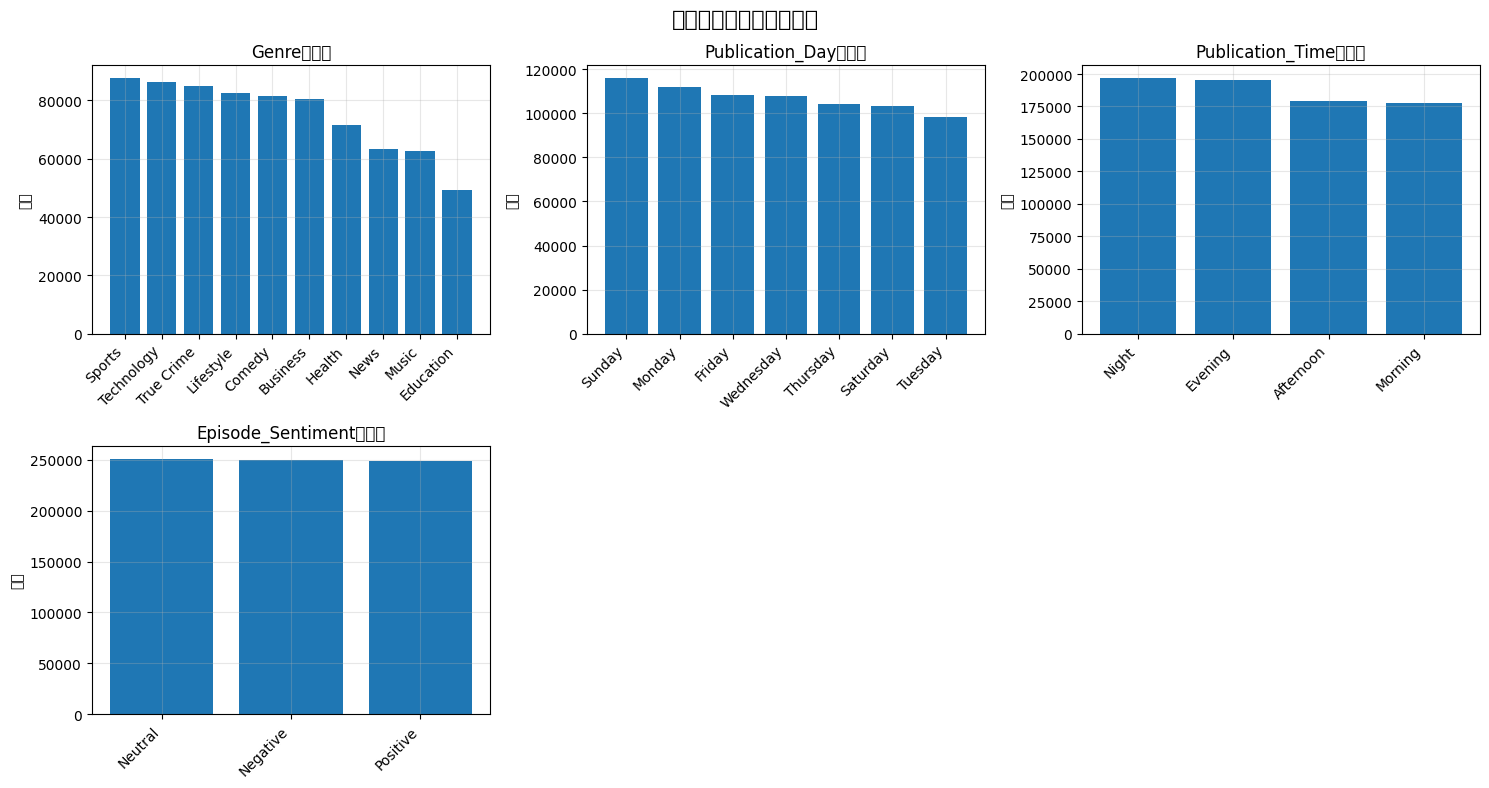

In [11]:
# カテゴリカル変数の可視化（ユニーク値が少ないものだけ）
categorical_cols_to_plot = [col for col in categorical_cols if train_df[col].nunique() <= 20]

if len(categorical_cols_to_plot) > 0:
    n_plots = min(len(categorical_cols_to_plot), 6)
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols_to_plot[:n_plots]):
        value_counts = train_df[col].value_counts()[:10]  # 上位10個まで
        axes[i].bar(range(len(value_counts)), value_counts.values)
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[i].set_title(f'{col}の分布')
        axes[i].set_ylabel('頻度')
        axes[i].grid(True, alpha=0.3)
    
    # 余ったサブプロットを非表示
    for i in range(n_plots, 6):
        axes[i].set_visible(False)
    
    plt.suptitle('カテゴリカル変数の分布', fontsize=16)
    plt.tight_layout()
    plt.show()

## 8. 相関分析

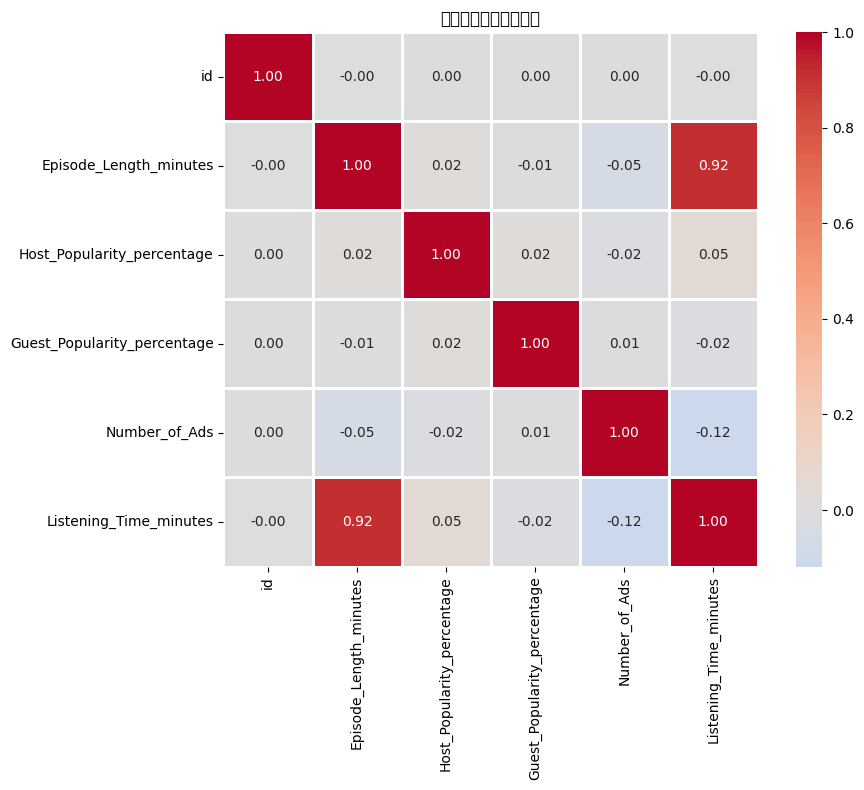


=== Listening_Time_minutesとの相関係数 ===
Listening_Time_minutes         1.000000
Episode_Length_minutes         0.916749
Host_Popularity_percentage     0.050870
id                            -0.000876
Guest_Popularity_percentage   -0.016014
Number_of_Ads                 -0.118337
Name: Listening_Time_minutes, dtype: float64


In [12]:
# 数値変数間の相関
if len(numerical_cols) > 1:
    correlation_matrix = train_df[numerical_cols].corr()
    
    # ヒートマップ
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
    plt.title('数値変数間の相関係数')
    plt.tight_layout()
    plt.show()
    
    # 目標変数との相関（目標変数がある場合）
    if target_col:
        target_corr = correlation_matrix[target_col].sort_values(ascending=False)
        print(f"\n=== {target_col}との相関係数 ===")
        print(target_corr)

## 9. 特徴量エンジニアリングのアイデア

In [13]:
# 特徴量エンジニアリングのアイデアをまとめる
print("=== 特徴量エンジニアリングのアイデア ===")
print()
print("1. 数値特徴量の変換:")
print("   - 対数変換（歪んだ分布の正規化）")
print("   - 標準化/正規化")
print("   - 多項式特徴量の作成")
print()
print("2. カテゴリカル変数のエンコーディング:")
print("   - ラベルエンコーディング")
print("   - ワンホットエンコーディング")
print("   - ターゲットエンコーディング")
print()
print("3. 特徴量の組み合わせ:")
print("   - 特徴量間の相互作用")
print("   - 比率や差分の計算")
print()
print("4. 時系列特徴量（もし日時データがあれば）:")
print("   - 曜日、時間帯などの抽出")
print("   - 周期性の考慮")

=== 特徴量エンジニアリングのアイデア ===

1. 数値特徴量の変換:
   - 対数変換（歪んだ分布の正規化）
   - 標準化/正規化
   - 多項式特徴量の作成

2. カテゴリカル変数のエンコーディング:
   - ラベルエンコーディング
   - ワンホットエンコーディング
   - ターゲットエンコーディング

3. 特徴量の組み合わせ:
   - 特徴量間の相互作用
   - 比率や差分の計算

4. 時系列特徴量（もし日時データがあれば）:
   - 曜日、時間帯などの抽出
   - 周期性の考慮


## 10. まとめ

In [14]:
print("=== EDA結果のまとめ ===")
print()
print(f"1. データサイズ:")
print(f"   - 訓練データ: {train_df.shape}")
print(f"   - テストデータ: {test_df.shape}")
print()
print(f"2. 特徴量:")
print(f"   - 数値変数: {len(numerical_cols)}個")
print(f"   - カテゴリカル変数: {len(categorical_cols)}個")
print()
print(f"3. 欠損値:")
if len(train_missing) > 0:
    print(f"   - 訓練データ: {len(train_missing)}カラムに欠損値あり")
else:
    print(f"   - 訓練データ: 欠損値なし")
if len(test_missing) > 0:
    print(f"   - テストデータ: {len(test_missing)}カラムに欠損値あり")
else:
    print(f"   - テストデータ: 欠損値なし")
print()
if target_col:
    print(f"4. 目標変数 ({target_col}):")
    print(f"   - 平均: {train_df[target_col].mean():.2f}")
    print(f"   - 標準偏差: {train_df[target_col].std():.2f}")
    print(f"   - 範囲: [{train_df[target_col].min():.2f}, {train_df[target_col].max():.2f}]")

=== EDA結果のまとめ ===

1. データサイズ:
   - 訓練データ: (750000, 12)
   - テストデータ: (250000, 11)

2. 特徴量:
   - 数値変数: 6個
   - カテゴリカル変数: 6個

3. 欠損値:
   - 訓練データ: 3カラムに欠損値あり
   - テストデータ: 2カラムに欠損値あり

4. 目標変数 (Listening_Time_minutes):
   - 平均: 45.44
   - 標準偏差: 27.14
   - 範囲: [0.00, 119.97]


## 11. 特徴量の重要度分析